In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install diffusers[torch] transformers
!pip install controlnet_aux
!pip install opencv-python
!pip install matplotlib
!pip install datasets
!pip install -U diffusers
!pip install -U transformers accelerate
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6

In [7]:
import cv2
import numpy as np
from PIL import Image
import os

# Function to extract edges from an image
def extract_edges(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Define dataset and output paths
dataset_path = "/content/drive/MyDrive/datafloor"  # Path to your dataset
output_path = "/content/drive/MyDrive/processed_dataset"  # Path to save processed images

# Create the output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Preprocess all images in your dataset
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)
    if os.path.isdir(label_path):
        # Create a subfolder in the output directory for each label
        output_label_path = os.path.join(output_path, label_folder)
        os.makedirs(output_label_path, exist_ok=True)

        # Process each image in the label folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            edges = extract_edges(image_path)
            # Save the processed image
            output_image_path = os.path.join(output_label_path, image_name)
            cv2.imwrite(output_image_path, edges)

print("Dataset preprocessing complete!")

Dataset preprocessing complete!


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FloorPlanDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Debug: Print the image folder being used
        print(f"Loading dataset from: {image_folder}")

        for label_folder in os.listdir(image_folder):
            label_path = os.path.join(image_folder, label_folder)
            if os.path.isdir(label_path):
                # Debug: Print the label folder being processed
                print(f"Processing label folder: {label_folder}")
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(label_folder.split("_")[0]))  # Extract label from folder name

        # Debug: Print the total number of images loaded
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import re  # Regular expressions for extracting numbers

class FloorPlanDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Debug: Print the image folder being used
        print(f"Loading dataset from: {image_folder}")

        for label_folder in os.listdir(image_folder):
            label_path = os.path.join(image_folder, label_folder)
            if os.path.isdir(label_path):
                # Debug: Print the label folder being processed
                print(f"Processing label folder: {label_folder}")

                # Extract the numeric part from the folder name (e.g., "3 rooms" -> 3)
                match = re.search(r'\d+', label_folder)  # Find the first number in the folder name
                if match:
                    label = int(match.group())  # Convert the numeric part to an integer
                else:
                    raise ValueError(f"Folder name '{label_folder}' does not contain a valid number.")

                # Process each image in the label folder
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)  # Use the extracted label

        # Debug: Print the total number of images loaded
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
import os

# Path to the original dataset
original_dataset_path = "/content/drive/MyDrive/datafloor"

# List all folders in the original dataset
folders = [f for f in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, f))]
print("Folders in original dataset:", folders)

Folders in original dataset: ['4 rooms', '5 rooms', '3 rooms']


In [11]:
# Path to the processed dataset
processed_dataset_path = "/content/drive/MyDrive/processed_dataset"

# List all folders in the processed dataset
folders = [f for f in os.listdir(processed_dataset_path) if os.path.isdir(os.path.join(processed_dataset_path, f))]
print("Folders in processed dataset:", folders)

Folders in processed dataset: ['4 rooms', '5 rooms', '3 rooms']


In [12]:
import cv2
import numpy as np
from PIL import Image
import os

# Function to extract edges from an image
def extract_edges(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Define dataset and output paths
dataset_path = "/content/drive/MyDrive/datafloor"  # Path to your original dataset
output_path = "/content/drive/MyDrive/processed_dataset"  # Path to save processed images

# Create the output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Preprocess all images in your dataset
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)
    if os.path.isdir(label_path):
        # Create a subfolder in the output directory for each label
        output_label_path = os.path.join(output_path, label_folder)
        os.makedirs(output_label_path, exist_ok=True)

        # Process each image in the label folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            edges = extract_edges(image_path)
            # Save the processed image
            output_image_path = os.path.join(output_label_path, image_name)
            cv2.imwrite(output_image_path, edges)

print("Dataset preprocessing complete!")

Dataset preprocessing complete!


In [13]:
from torchvision import transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Create dataset
dataset = FloorPlanDataset(image_folder="/content/drive/MyDrive/processed_dataset", transform=transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Debug: Print a batch of data
for batch in dataloader:
    images, labels = batch
    print("Batch images shape:", images.shape)
    print("Batch labels:", labels)
    break

Loading dataset from: /content/drive/MyDrive/processed_dataset
Processing label folder: 4 rooms
Processing label folder: 5 rooms
Processing label folder: 3 rooms
Total images loaded: 510
Batch images shape: torch.Size([4, 3, 512, 512])
Batch labels: tensor([3, 5, 4, 4])


In [14]:
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline
import torch

# Load ControlNet model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")

# Load Stable Diffusion model with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
from torch.optim import AdamW
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F

# Load the tokenizer and text encoder for Stable Diffusion
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")

# Define optimizer
optimizer = AdamW(controlnet.parameters(), lr=1e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    controlnet.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        control_images, labels = batch
        control_images = control_images.to("cuda")

        # Zero gradients
        optimizer.zero_grad()

        # Prepare text embeddings with proper padding
        text_inputs = tokenizer(
            [f"{label}-room floor plan" for label in labels],
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_input_ids = text_inputs.input_ids.to("cuda")

        # Get text embeddings
        with torch.no_grad():
            text_embeddings = text_encoder(text_input_ids)[0]

        # Create appropriate noise sample - make sure dimensions match UNet expectations
        # Check the expected channel dimension of your UNet
        batch_size = control_images.shape[0]

        # Most SD models expect 4 channels for latents
        # The spatial dimensions should be 1/8 of the original image size
        # For 512×512 images, latents would be 64×64
        latent_height, latent_width = 64, 64
        noise = torch.randn(
            (batch_size, 4, latent_height, latent_width),
            device="cuda"
        )

        # Generate random timesteps
        timesteps = torch.randint(
            0, 1000, (batch_size,),
            device="cuda"
        ).long()

        # Make sure control images match expected input shape
        # If control_images aren't already transformed to match ControlNet's expected input
        # Add a transformation here if needed

        # Forward pass through ControlNet
        try:
            down_block_res_samples, mid_block_res_sample = controlnet(
                sample=noise,
                timestep=timesteps,
                encoder_hidden_states=text_embeddings,
                controlnet_cond=control_images,
                return_dict=False,
            )

            # Simple loss example (regularize outputs)
            loss = 0
            for res_sample in down_block_res_samples:
                loss += res_sample.pow(2).mean()
            loss += mid_block_res_sample.pow(2).mean()

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        except Exception as e:
            print(f"Error in batch: {e}")
            print(f"Text embeddings shape: {text_embeddings.shape}")
            print(f"Control images shape: {control_images.shape}")
            print(f"Noise shape: {noise.shape}")
            # Skip problematic batch
            continue

    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1} Loss: {avg_epoch_loss}")

# Save the fine-tuned model
controlnet.save_pretrained("/content/drive/MyDrive/fine_tuned_controlnet")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epoch 1/3


  1%|          | 1/128 [00:02<04:51,  2.30s/it]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 2/128 [00:02<02:15,  1.07s/it]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

  2%|▏         | 3/128 [00:02<01:40,  1.25it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  3%|▎         | 4/128 [00:04<01:52,  1.10it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  4%|▍         | 5/128 [00:04<01:29,  1.38it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▍         | 6/128 [00:04<01:17,  1.58it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▌         | 7/128 [00:05<01:11,  1.69it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  7%|▋         | 9/128 [00:05<00:44,  2.68it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▊         | 11/128 [00:06<00:28,  4.10it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 10%|█         | 13/128 [00:06<00:21,  5.29it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 11%|█         | 14/128 [00:06<00:19,  5.71it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▎        | 16/128 [00:06<00:18,  6.13it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 14%|█▍        | 18/128 [00:07<00:17,  6.31it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▌        | 20/128 [00:07<00:16,  6.37it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 17%|█▋        | 22/128 [00:07<00:15,  6.96it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 19%|█▉        | 24/128 [00:07<00:15,  6.65it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|██        | 26/128 [00:08<00:14,  7.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 22%|██▏       | 28/128 [00:08<00:15,  6.60it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 30/128 [00:08<00:13,  7.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 25%|██▌       | 32/128 [00:09<00:13,  7.18it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 34/128 [00:09<00:13,  6.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 28%|██▊       | 36/128 [00:09<00:13,  6.77it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|██▉       | 38/128 [00:09<00:12,  7.03it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 31%|███▏      | 40/128 [00:10<00:13,  6.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 33%|███▎      | 42/128 [00:10<00:12,  6.77it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▍      | 44/128 [00:10<00:11,  7.11it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 36%|███▌      | 46/128 [00:11<00:11,  7.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 48/128 [00:11<00:10,  7.35it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 39%|███▉      | 50/128 [00:11<00:10,  7.64it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████      | 52/128 [00:11<00:10,  7.32it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 42%|████▏     | 54/128 [00:12<00:10,  6.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 44%|████▍     | 56/128 [00:12<00:10,  7.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▌     | 58/128 [00:12<00:10,  6.69it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 47%|████▋     | 60/128 [00:13<00:10,  6.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 61/128 [00:13<00:10,  6.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 62/128 [00:13<00:11,  5.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 49%|████▉     | 63/128 [00:13<00:11,  5.42it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 50%|█████     | 64/128 [00:13<00:12,  5.18it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 51%|█████     | 65/128 [00:14<00:12,  5.05it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 66/128 [00:14<00:12,  4.99it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 53%|█████▎    | 68/128 [00:14<00:12,  4.68it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▍    | 70/128 [00:15<00:11,  5.16it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▌    | 71/128 [00:15<00:11,  4.79it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 57%|█████▋    | 73/128 [00:15<00:11,  4.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 58%|█████▊    | 74/128 [00:16<00:11,  4.67it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▊    | 75/128 [00:16<00:11,  4.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 60%|██████    | 77/128 [00:16<00:11,  4.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▏   | 79/128 [00:17<00:09,  5.07it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 63%|██████▎   | 81/128 [00:17<00:08,  5.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 65%|██████▍   | 83/128 [00:17<00:06,  6.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▋   | 85/128 [00:17<00:06,  7.04it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 68%|██████▊   | 87/128 [00:18<00:05,  7.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|██████▉   | 89/128 [00:18<00:05,  7.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 71%|███████   | 91/128 [00:18<00:04,  7.92it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 93/128 [00:19<00:04,  7.05it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 74%|███████▍  | 95/128 [00:19<00:04,  6.93it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 76%|███████▌  | 97/128 [00:19<00:04,  6.92it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 99/128 [00:19<00:04,  7.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 79%|███████▉  | 101/128 [00:20<00:04,  6.35it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|████████  | 103/128 [00:20<00:03,  6.67it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 82%|████████▏ | 105/128 [00:20<00:03,  6.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▎ | 107/128 [00:21<00:02,  7.07it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 85%|████████▌ | 109/128 [00:21<00:02,  7.50it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 87%|████████▋ | 111/128 [00:21<00:02,  7.06it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 113/128 [00:21<00:02,  6.56it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 90%|████████▉ | 115/128 [00:22<00:01,  6.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████▏| 117/128 [00:22<00:01,  6.98it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 93%|█████████▎| 119/128 [00:22<00:01,  6.88it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▍| 121/128 [00:23<00:00,  7.26it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 96%|█████████▌| 123/128 [00:23<00:00,  7.51it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 125/128 [00:23<00:00,  7.59it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 99%|█████████▉| 127/128 [00:23<00:00,  7.85it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:23<00:00,  5.36it/s]


Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 1 Loss: 0.0
Epoch 2/3


  1%|          | 1/128 [00:00<00:19,  6.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 2/128 [00:00<00:16,  7.71it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 3/128 [00:00<00:16,  7.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  3%|▎         | 4/128 [00:00<00:15,  7.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  4%|▍         | 5/128 [00:00<00:16,  7.51it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▍         | 6/128 [00:00<00:17,  7.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▌         | 7/128 [00:00<00:16,  7.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  6%|▋         | 8/128 [00:01<00:15,  7.63it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  7%|▋         | 9/128 [00:01<00:15,  7.90it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  8%|▊         | 10/128 [00:01<00:15,  7.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▊         | 11/128 [00:01<00:16,  7.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▉         | 12/128 [00:01<00:15,  7.45it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 10%|█         | 13/128 [00:01<00:15,  7.30it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 11%|█         | 14/128 [00:01<00:16,  7.02it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▏        | 15/128 [00:02<00:14,  7.61it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▎        | 16/128 [00:02<00:13,  8.05it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 13%|█▎        | 17/128 [00:02<00:14,  7.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 14%|█▍        | 18/128 [00:02<00:14,  7.46it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 15%|█▍        | 19/128 [00:02<00:14,  7.37it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▌        | 20/128 [00:02<00:14,  7.45it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▋        | 21/128 [00:02<00:14,  7.36it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 17%|█▋        | 22/128 [00:02<00:15,  6.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 18%|█▊        | 23/128 [00:03<00:14,  7.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 19%|█▉        | 24/128 [00:03<00:15,  6.62it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|██        | 26/128 [00:03<00:16,  6.06it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 21%|██        | 27/128 [00:03<00:19,  5.16it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 22%|██▏       | 28/128 [00:04<00:20,  4.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 30/128 [00:04<00:19,  4.93it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 24%|██▍       | 31/128 [00:04<00:18,  5.15it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 25%|██▌       | 32/128 [00:04<00:19,  5.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 34/128 [00:05<00:18,  5.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 28%|██▊       | 36/128 [00:05<00:17,  5.31it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|██▉       | 38/128 [00:06<00:16,  5.60it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|███       | 39/128 [00:06<00:15,  5.60it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 31%|███▏      | 40/128 [00:06<00:18,  4.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 33%|███▎      | 42/128 [00:06<00:17,  4.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▍      | 44/128 [00:07<00:15,  5.46it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 36%|███▌      | 46/128 [00:07<00:13,  6.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 48/128 [00:07<00:11,  6.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 39%|███▉      | 50/128 [00:07<00:10,  7.22it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████      | 52/128 [00:08<00:09,  7.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 42%|████▏     | 54/128 [00:08<00:09,  8.10it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 44%|████▍     | 56/128 [00:08<00:08,  8.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▌     | 58/128 [00:08<00:09,  7.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 47%|████▋     | 60/128 [00:09<00:10,  6.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 62/128 [00:09<00:09,  7.07it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 50%|█████     | 64/128 [00:09<00:08,  7.44it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 66/128 [00:10<00:08,  7.67it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 53%|█████▎    | 68/128 [00:10<00:07,  7.94it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▍    | 70/128 [00:10<00:07,  8.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 56%|█████▋    | 72/128 [00:10<00:07,  7.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 58%|█████▊    | 74/128 [00:11<00:07,  7.52it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▉    | 76/128 [00:11<00:06,  7.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 61%|██████    | 78/128 [00:11<00:06,  7.96it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▎   | 80/128 [00:11<00:06,  7.50it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 64%|██████▍   | 82/128 [00:12<00:06,  7.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▌   | 84/128 [00:12<00:05,  7.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 67%|██████▋   | 86/128 [00:12<00:05,  7.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 69%|██████▉   | 88/128 [00:13<00:05,  6.87it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|███████   | 90/128 [00:13<00:05,  7.04it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 72%|███████▏  | 92/128 [00:13<00:04,  7.44it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 94/128 [00:13<00:04,  7.06it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 75%|███████▌  | 96/128 [00:14<00:04,  6.76it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 98/128 [00:14<00:04,  6.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 78%|███████▊  | 100/128 [00:14<00:03,  7.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|███████▉  | 102/128 [00:14<00:03,  7.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 81%|████████▏ | 104/128 [00:15<00:03,  7.92it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 83%|████████▎ | 106/128 [00:15<00:02,  7.69it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▍ | 108/128 [00:15<00:02,  7.78it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 86%|████████▌ | 110/128 [00:16<00:02,  7.33it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 112/128 [00:16<00:02,  7.04it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 89%|████████▉ | 114/128 [00:16<00:02,  6.80it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████ | 116/128 [00:16<00:01,  7.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████▏| 117/128 [00:17<00:01,  6.91it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 93%|█████████▎| 119/128 [00:17<00:01,  5.65it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▍| 121/128 [00:17<00:01,  5.31it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▌| 122/128 [00:18<00:01,  5.29it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 97%|█████████▋| 124/128 [00:18<00:00,  5.12it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 125/128 [00:18<00:00,  5.19it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 126/128 [00:18<00:00,  4.94it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:19<00:00,  6.65it/s]


Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 2 Loss: 0.0
Epoch 3/3


  1%|          | 1/128 [00:00<00:33,  3.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 2/128 [00:00<00:30,  4.09it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  2%|▏         | 3/128 [00:00<00:29,  4.28it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  3%|▎         | 4/128 [00:00<00:28,  4.42it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▍         | 6/128 [00:01<00:25,  4.82it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  5%|▌         | 7/128 [00:01<00:24,  4.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  7%|▋         | 9/128 [00:01<00:23,  5.07it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


  9%|▊         | 11/128 [00:02<00:18,  6.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 10%|█         | 13/128 [00:02<00:16,  7.01it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 12%|█▏        | 15/128 [00:02<00:15,  7.47it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 13%|█▎        | 17/128 [00:02<00:15,  7.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 15%|█▍        | 19/128 [00:03<00:14,  7.32it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 16%|█▋        | 21/128 [00:03<00:13,  7.76it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 18%|█▊        | 23/128 [00:03<00:13,  7.68it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 20%|█▉        | 25/128 [00:04<00:13,  7.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 21%|██        | 27/128 [00:04<00:12,  8.29it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 23%|██▎       | 29/128 [00:04<00:12,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 24%|██▍       | 31/128 [00:04<00:12,  7.50it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 26%|██▌       | 33/128 [00:05<00:12,  7.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 27%|██▋       | 35/128 [00:05<00:13,  7.00it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 29%|██▉       | 37/128 [00:05<00:13,  6.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 30%|███       | 39/128 [00:05<00:12,  7.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 32%|███▏      | 41/128 [00:06<00:12,  7.19it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 34%|███▎      | 43/128 [00:06<00:12,  6.97it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 35%|███▌      | 45/128 [00:06<00:11,  7.05it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 37%|███▋      | 47/128 [00:07<00:12,  6.68it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 38%|███▊      | 49/128 [00:07<00:11,  6.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 40%|███▉      | 51/128 [00:07<00:11,  6.93it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 41%|████▏     | 53/128 [00:07<00:11,  6.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 43%|████▎     | 55/128 [00:08<00:10,  6.95it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 45%|████▍     | 57/128 [00:08<00:09,  7.11it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 46%|████▌     | 59/128 [00:08<00:09,  7.63it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 48%|████▊     | 61/128 [00:09<00:09,  7.12it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 49%|████▉     | 63/128 [00:09<00:08,  7.54it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 51%|█████     | 65/128 [00:09<00:08,  7.87it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 52%|█████▏    | 67/128 [00:09<00:07,  8.24it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 54%|█████▍    | 69/128 [00:10<00:07,  8.07it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 55%|█████▌    | 71/128 [00:10<00:07,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 57%|█████▋    | 73/128 [00:10<00:07,  7.83it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 59%|█████▊    | 75/128 [00:10<00:08,  6.60it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 60%|██████    | 77/128 [00:11<00:07,  6.85it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 62%|██████▏   | 79/128 [00:11<00:06,  7.25it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 63%|██████▎   | 81/128 [00:11<00:06,  6.81it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 64%|██████▍   | 82/128 [00:12<00:08,  5.48it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▌   | 84/128 [00:12<00:08,  5.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 66%|██████▋   | 85/128 [00:12<00:08,  5.08it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 68%|██████▊   | 87/128 [00:13<00:08,  4.98it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|██████▉   | 89/128 [00:13<00:07,  5.49it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 70%|███████   | 90/128 [00:13<00:07,  5.17it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 72%|███████▏  | 92/128 [00:14<00:06,  5.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 73%|███████▎  | 93/128 [00:14<00:06,  5.22it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 74%|███████▍  | 95/128 [00:14<00:06,  4.93it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 75%|███████▌  | 96/128 [00:14<00:06,  4.82it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 77%|███████▋  | 98/128 [00:15<00:06,  4.84it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 78%|███████▊  | 100/128 [00:15<00:05,  5.36it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 80%|███████▉  | 102/128 [00:16<00:04,  5.38it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 81%|████████▏ | 104/128 [00:16<00:03,  6.34it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 83%|████████▎ | 106/128 [00:16<00:03,  6.72it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 84%|████████▍ | 108/128 [00:16<00:02,  7.11it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 86%|████████▌ | 110/128 [00:17<00:02,  7.03it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 88%|████████▊ | 112/128 [00:17<00:02,  7.27it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 89%|████████▉ | 114/128 [00:17<00:01,  7.38it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 91%|█████████ | 116/128 [00:17<00:01,  7.88it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 92%|█████████▏| 118/128 [00:18<00:01,  7.86it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 94%|█████████▍| 120/128 [00:18<00:00,  8.03it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 95%|█████████▌| 122/128 [00:18<00:00,  7.89it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 97%|█████████▋| 124/128 [00:18<00:00,  7.20it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


 98%|█████████▊| 126/128 [00:19<00:00,  6.96it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])


100%|██████████| 128/128 [00:19<00:00,  6.58it/s]

Error in batch: mat1 and mat2 shapes cannot be multiplied (308x512 and 768x320)
Text embeddings shape: torch.Size([4, 77, 512])
Control images shape: torch.Size([4, 3, 512, 512])
Noise shape: torch.Size([4, 4, 64, 64])
Error in batch: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)
Text embeddings shape: torch.Size([2, 77, 512])
Control images shape: torch.Size([2, 3, 512, 512])
Noise shape: torch.Size([2, 4, 64, 64])
Epoch 3 Loss: 0.0


In [16]:
# Install FastAPI, Uvicorn, and ngrok
!pip install fastapi uvicorn pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00


In [17]:
!pip install python-multipart

In [18]:
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse, StreamingResponse
from PIL import Image
import io

In [19]:
# Initialize FastAPI app
app = FastAPI()

# Load the fine-tuned ControlNet model (from Cell 12)
fine_tuned_controlnet = ControlNetModel.from_pretrained(
    "/content/drive/MyDrive/fine_tuned_controlnet"
).to("cuda")

# Load Stable Diffusion with the fine-tuned ControlNet (from Cell 12)
fine_tuned_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=fine_tuned_controlnet,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
!pip install fastapi uvicorn pyngrok nest_asyncio

Image shape: (839, 1386, 3)


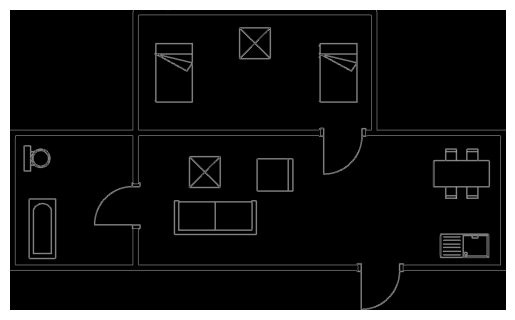

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Open the image
control_image = Image.open(control_image_path).convert("RGB")

# Convert to NumPy array and check shape
image_array = np.array(control_image)
print("Image shape:", image_array.shape)  # Should be (height, width, 3) for RGB

# Show image
plt.imshow(control_image)
plt.axis("off")
plt.show()


In [22]:
# Import necessary libraries
from flask import Flask, request, render_template_string, send_file, jsonify
from PIL import Image
import io
import threading
from pyngrok import ngrok
import nest_asyncio

# Apply nest_asyncio to allow Flask to run in a notebook environment
nest_asyncio.apply()

# Kill any existing tunnels to avoid the 3-tunnel limit error
ngrok.kill()

# Initialize Flask app
app = Flask(__name__)

# Load the fixed control image (Replace with actual path)
control_image_path = "/content/drive/MyDrive/processed_dataset/3 rooms/Cat10_1.jpg"
control_image = Image.open(control_image_path).convert("RGB")
print("image mode:", control_image.mode)

control_image = control_image.resize((512, 512))  # Resize to match model input

# Dummy model function (Replace this with your actual AI model call)
def pipe(prompt, image, num_inference_steps):
    class DummyResult:
        def __init__(self, img):
            self.images = [img.convert("RGB")]
    return DummyResult(image)

# Debugging route to confirm the server is running
@app.route("/", methods=["GET"])
def home():
    return render_template_string('''
    <html>
    <head>
        <title>Image Generator</title>
        <style>
            body { font-family: Arial, sans-serif; text-align: center; margin: 20px; }
            input, button { padding: 10px; font-size: 16px; }
            img { margin-top: 20px; max-width: 500px; border: 2px solid black; }
        </style>
        <script>
            function generateImage() {
                var prompt = document.getElementById("prompt").value;
                fetch("/generate", {
                    method: "POST",
                    headers: { "Content-Type": "application/json" },
                    body: JSON.stringify({ prompt: prompt })
                })
                .then(response => response.blob())
                .then(blob => {
                    var imgUrl = URL.createObjectURL(blob);
                    document.getElementById("outputImage").src = imgUrl;
                })
                .catch(error => console.error("Error:", error));
            }
        </script>
    </head>
    <body>
        <h2>Enter Prompt to Generate Image</h2>
        <input type="text" id="prompt" placeholder="Enter your prompt here" required>
        <button onclick="generateImage()">Generate</button>
        <br>
        <img id="outputImage" src="" alt="Generated Image">
    </body>
    </html>
    ''')

# API Endpoint to generate image
@app.route("/generate", methods=["POST"])
def generate_image():
    try:
        data = request.get_json()
        if not data or 'prompt' not in data:
            return jsonify({"error": "Missing 'prompt' in request body"}), 400
        print("Control image mode before pipe:", control_image.mode)
        prompt = data['prompt']
        result = pipe(prompt=prompt, image=control_image, num_inference_steps=50)

        image = result.images[0]

        image = image.convert("RGB")

        # Convert image to bytes
        img_io = io.BytesIO()
        image.save(img_io, format="PNG")
        img_io.seek(0)

        return send_file(img_io, mimetype="image/png")
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Set your ngrok authtoken (replace with your actual token)
ngrok.set_auth_token("2uhK4PabDbTf26OquWy3xbvDHUK_maFmJc7y52fBYWZszd2T")

# Open an ngrok tunnel on port 5000 where your Flask app is running
public_url = ngrok.connect(5000).public_url
print("🚀 Public URL:", public_url)

# Function to run the Flask server
def run_flask():
    app.run(host="0.0.0.0", port=5000)

# Start the Flask server in a background thread
server_thread = threading.Thread(target=run_flask, daemon=True)
server_thread.start()


image mode: RGB
🚀 Public URL: https://254c-34-87-186-235.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


In [5]:
!fuser -k 5000/tcp
!pkill -f ngrok


In [13]:
print("Original dataset image mode:", control_image.mode)


Original dataset image mode: RGB


In [22]:
!ngrok config add-authtoken 2uhK4PabDbTf26OquWy3xbvDHUK_maFmJc7y52fBYWZszd2T

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [27]:
from pyngrok import ngrok

# Kill all existing tunnels
ngrok.kill()


In [23]:
from pyngrok import ngrok

# Start ngrok tunnel
ngrok_tunnel = ngrok.connect(8001)
print("Public URL:", ngrok_tunnel.public_url)

Public URL: https://2f81-34-87-186-235.ngrok-free.app


In [9]:
# Generate a floor plan (for testing purposes)
prompt = "Generate a 3 bedroom floor plan"
control_image = Image.open("/content/drive/MyDrive/processed_dataset/3 rooms/Cat10_1.jpg")
control_image = control_image.resize((512, 512))
output_image = fine_tuned_pipe(prompt, control_image, num_inference_steps=50).images[0]

# Save the generated image (optional)
output_image.save("/content/drive/MyDrive/generated_floor_plan.png")
print("Generated image saved!")

NameError: name 'fine_tuned_pipe' is not defined

In [ ]:
# Save and display the generated image (optional)
output_image.save("/content/drive/MyDrive/generated_floor_plan.png")
print("Generated image saved!")

Generated image saved!
